In [1]:
import pandas as pd
import os 
import folium
from folium import plugins

In [2]:
inspection = pd.read_csv('../Food_Establishment_Inspection_Data.csv')
inspection.head(5)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Name,Program Identifier,Inspection Date,Description,Address,City,Zip Code,Phone,Longitude,Latitude,...,Inspection Score,Inspection Result,Inspection Closed Business,Violation Type,Violation Description,Violation Points,Business_ID,Inspection_Serial_Num,Violation_Record_ID,Grade
0,"@ THE SHACK, LLC",SHACK COFFEE,08/03/2019,Seating 0-12 - Risk Category III,2920 SW AVALON WAY,Seattle,98126,(206) 938-5665,-122.370913,47.570425,...,5.0,Satisfactory,False,BLUE,4100 - Warewashing facilities properly install...,5,PR0048053,DAAWCFJXT,IVAW6QGCN,1.0
1,"@ THE SHACK, LLC",SHACK COFFEE,10/03/2018,Seating 0-12 - Risk Category III,2920 SW AVALON WAY,Seattle,98126,(206) 938-5665,-122.370913,47.570425,...,10.0,Satisfactory,False,BLUE,"3400 - Wiping cloths properly used, stored, pr...",5,PR0048053,DA1RU2P4A,IVM00AWOV,1.0
2,"@ THE SHACK, LLC",SHACK COFFEE,10/03/2018,Seating 0-12 - Risk Category III,2920 SW AVALON WAY,Seattle,98126,(206) 938-5665,-122.370913,47.570425,...,10.0,Satisfactory,False,BLUE,4100 - Warewashing facilities properly install...,5,PR0048053,DA1RU2P4A,IVTPKYPPP,1.0
3,"@ THE SHACK, LLC",SHACK COFFEE,04/02/2018,Seating 0-12 - Risk Category III,2920 SW AVALON WAY,Seattle,98126,(206) 938-5665,-122.370913,47.570425,...,0.0,Complete,False,NaN,NaN,0,PR0048053,DA34JMIOR,NaN,1.0
4,"@ THE SHACK, LLC",SHACK COFFEE,07/27/2017,Seating 0-12 - Risk Category III,2920 SW AVALON WAY,Seattle,98126,(206) 938-5665,-122.370913,47.570425,...,0.0,Satisfactory,False,NaN,NaN,0,PR0048053,DADNXR5VS,NaN,1.0


In [3]:
# convert dates in 'Inspection Date' to date time
inspection['Inspection Date']=pd.to_datetime(inspection['Inspection Date']) 

# sort by inspection date then remove duplicates
sorted = inspection.sort_values(by=['Inspection Date']).drop_duplicates(subset = ['Program Identifier', 'Address'], keep = 'last')
# drop all nan, nat etc
sorted = sorted.dropna()


In [4]:
len(sorted)

3226

In [18]:
# Create a map centered on Canlis in Seattle, WA
m = folium.Map(
        tiles='Stamen Toner',
        location=[47.6, -122.346742],
        zoom_start = 11
        )

# cluster points
marker_cluster = folium.plugins.MarkerCluster().add_to(m)

# Add marker for each restaurant in the database
for i, r in sorted.tail(1200).iterrows():
    folium.Marker(
        # pull lat and lon from entry and use as coordinates for the marker
        location=[r['Latitude'],r['Longitude']],
        # use the business name as the pop
        popup='Restaurant: '+str(r['Inspection Business Name'])+
               '<br>Rating: '+str(r['Inspection Result'])+
                '<br>Date: '+str(r['Inspection Date']),
        icon=folium.Icon()
    ).add_to(marker_cluster)

# Display m
m

In [8]:
import altair as alt

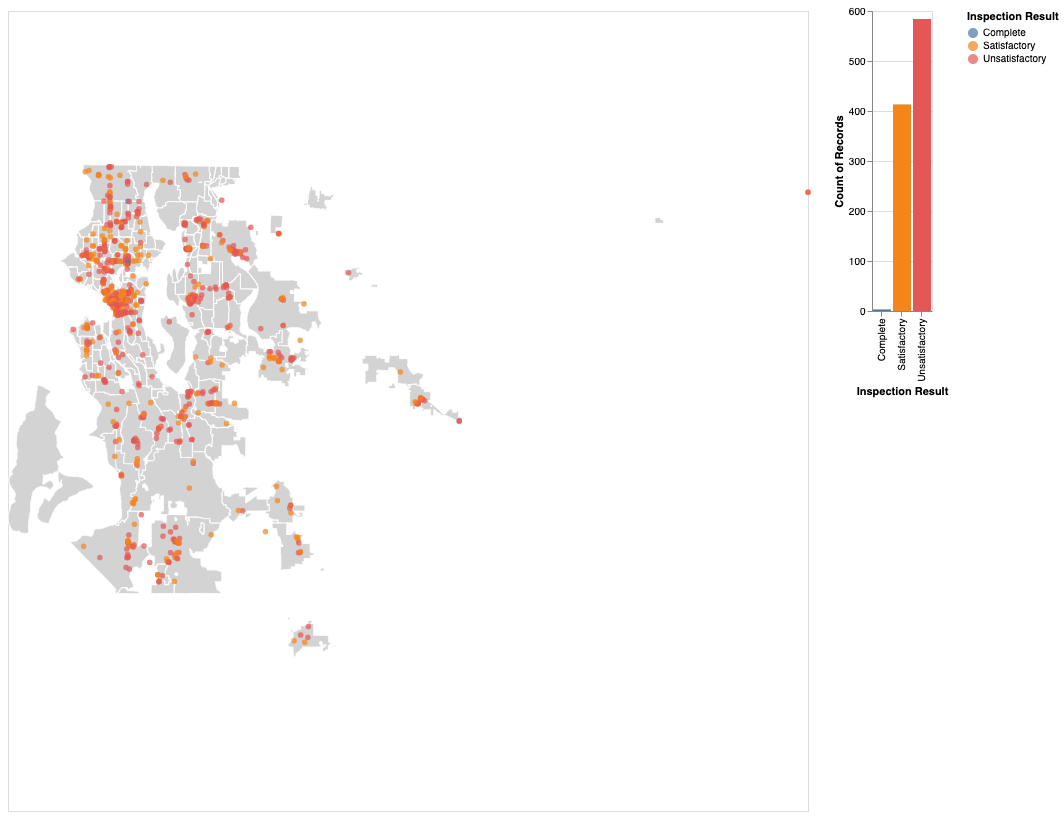

In [60]:
# remote geojson data object
url_geojson = 'https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/neighborhoods.geojson'
data_geojson_remote = alt.Data(url=url_geojson, format=alt.DataFormat(property='features',type='json'))

# interaction, select bar from historgram
multi = alt.selection_multi(encodings = ['x'],resolve = 'intersect')

# Seattle background
background = alt.Chart(data_geojson_remote).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=800,
    height=800)

# add a few restaurants
sorted10 = sorted.head(1000)
restaurants = alt.Chart(sorted10).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    tooltip = ['Inspection Business Name','Inspection Result','Inspection Score'],
    color = 'Inspection Result:N'
).transform_filter(multi)

# histogram of inspection results
hist = alt.Chart(sorted10).mark_bar().encode(
    x = 'Inspection Result:N',
    y = 'count()',
    color = 'Inspection Result:N')


hist_select = alt.layer(
    hist.add_selection(multi).encode(color=alt.value('lightgrey')),
    hist.transform_filter(multi)
)

background + restaurants | hist_select